In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import numpy as np
import math
import matplotlib.pyplot as plt
import io
import os

In [2]:
train_file = 'shakespeare_train.txt'
val_file = 'shakespeare_valid.txt'
with io.open(train_file,'r',encoding='utf8') as f :
    train = f.read().lower()

with io.open(val_file,'r',encoding='utf8') as f :
    val = f.read().lower()

In [3]:
# The unique characters in the file
vocab = sorted(set(train))
print(f'{len(vocab)} unique characters')
print(train[:200])

41 unique characters
first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you


In [4]:
character_to_int = {}
int_to_character = {}
for i,character in enumerate(vocab):
    character_to_int[character] = i
    int_to_character[i] = character

print(character_to_int.items())

dict_items([('\n', 0), (' ', 1), ('!', 2), ('$', 3), ('&', 4), ("'", 5), (',', 6), ('-', 7), ('.', 8), ('3', 9), (':', 10), (';', 11), ('?', 12), ('[', 13), (']', 14), ('a', 15), ('b', 16), ('c', 17), ('d', 18), ('e', 19), ('f', 20), ('g', 21), ('h', 22), ('i', 23), ('j', 24), ('k', 25), ('l', 26), ('m', 27), ('n', 28), ('o', 29), ('p', 30), ('q', 31), ('r', 32), ('s', 33), ('t', 34), ('u', 35), ('v', 36), ('w', 37), ('x', 38), ('y', 39), ('z', 40)])


In [5]:
train_id = [character_to_int[character] for character in train]
val_id = [character_to_int[character] for character in val]
print(f'number of characters in training data: {len(train_id)}')
print(f'number of characters in validation data: {len(val)}')

number of characters in training data: 4351312
number of characters in validation data: 222025


In [6]:
def prepare_data(text, maxlen, step):
    sentences = []    # This holds our input sequences
    next_chars = []    # This holds the targets (the next characters)
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    
    sentence_one_hot = np.zeros((len(sentences), maxlen, len(vocab)))
    next_char_one_hot = np.zeros((len(sentences), len(vocab)))
    for i in range(len(sentences)):
        next_char_one_hot[i,next_chars[i]] = 1
        for j in range(maxlen):
            sentence_one_hot[i,j,sentences[i][j]] = 1
    
    return sentence_one_hot, next_char_one_hot

In [7]:
train_x, train_y = prepare_data(train_id, 100, 5)
val_x, val_y = prepare_data(val_id, 100, 5)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(870243, 100, 41) (870243, 41)
(44385, 100, 41) (44385, 41)


In [8]:
def BPC_loss(y_true, y_pred):
    loss =  - tf.reduce_mean(tf.reduce_sum(y_true * tf.experimental.numpy.log2((y_pred)),axis = 1))
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vocab_size = len(vocab)
def build_model(maxlen, hidden_states):
    model=models.Sequential()      
    model.add(tf.keras.layers.LSTM(hidden_states, input_shape=(maxlen, len(vocab))))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(layers.Dense(vocab_size, activation = 'softmax'))
    model.compile(optimizer=optimizer, loss = BPC_loss, metrics=['categorical_accuracy'])
    return model

In [9]:
model = build_model(100, 256)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               305152    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 41)                10537     
Total params: 315,689
Trainable params: 315,689
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Directory where the checkpoints will be saved
checkpoint_dir = './LSTM_training_ckpts'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [11]:
history = model.fit(
      train_x, train_y,
      epochs = 20,
      batch_size = 64,
      validation_data=(val_x, val_y),
      callbacks=[checkpoint_callback]
      #verbose = 0
)

Epoch 1/20
13598/13598 [==============================] - 120s 8ms/step - loss: 2.8053 - categorical_accuracy: 0.4227 - val_loss: 2.4462 - val_categorical_accuracy: 0.4888
Epoch 2/20
13598/13598 [==============================] - 106s 8ms/step - loss: 2.3425 - categorical_accuracy: 0.5067 - val_loss: 2.2847 - val_categorical_accuracy: 0.5188
Epoch 3/20
13598/13598 [==============================] - 107s 8ms/step - loss: 2.2023 - categorical_accuracy: 0.5330 - val_loss: 2.2331 - val_categorical_accuracy: 0.5306
Epoch 4/20
13598/13598 [==============================] - 105s 8ms/step - loss: 2.1250 - categorical_accuracy: 0.5475 - val_loss: 2.1930 - val_categorical_accuracy: 0.5389
Epoch 5/20
13598/13598 [==============================] - 105s 8ms/step - loss: 2.0764 - categorical_accuracy: 0.5568 - val_loss: 2.1784 - val_categorical_accuracy: 0.5409
Epoch 6/20
13598/13598 [==============================] - 105s 8ms/step - loss: 2.0394 - categorical_accuracy: 0.5629 - val_loss: 2.1660 - v

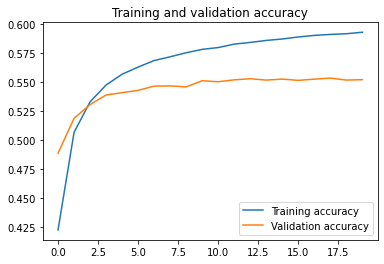

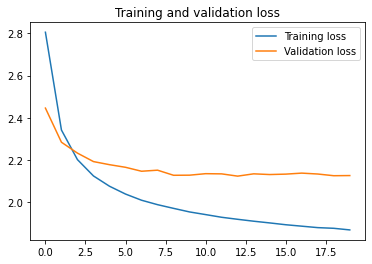

In [12]:
# plot the training curve and layer's weight
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

def plot_training(train_loss,val_loss,title,metrix):
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, '-', label='Training '+metrix)
    plt.plot(epochs, val_loss, '-', label='Validation '+metrix)
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_training(acc,val_acc,'Training and validation accuracy', 'accuracy')
plot_training(loss,val_loss,'Training and validation loss', 'loss')

In [13]:
def sample_character(preds, temperature = 0.6):
    # more temperature, more sparse
    logits = np.log(preds)/temperature
    preds = tf.nn.softmax(logits, axis=None, name=None).numpy() 
    predicted_ids = np.random.choice(len(preds), 1, p=preds)[0]
    
    return predicted_ids

In [14]:
def generate_sequence(input_seq, model, predicted_len = 1000):
    result = []
    for i in range(predicted_len):
        preds = model.predict(np.expand_dims(input_seq, axis = 0))[0]
        predicted_ids = sample_character(preds)
        result.append(int_to_character[predicted_ids])
        predicted_one_hot = np.zeros((1,len(vocab)))
        predicted_one_hot[0,predicted_ids] = 1
        input_seq = np.concatenate((input_seq[1:], predicted_one_hot), axis = 0)
        
    return result

In [15]:
import sys

def print_result(start_chars, chars):
    for char in start_chars:
        sys.stdout.write(char)
        sys.stdout.flush()
    for char in chars:
        sys.stdout.write(char)
        sys.stdout.flush()

In [16]:
start_sample_id = 0
result = generate_sequence(train_x[start_sample_id], model)

In [17]:
print_result(train[100*start_sample_id:100*(start_sample_id+1)], result)

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you shall profess to this name the man laughter.

paris:
well see the world, and here i have to-morrow
enough to god have a wife and soldier.
and was the general of it not so bands!

captain:
this is for the state of the dear love that where
the given her waters do her fall out and
the belles did the other than the bowels keeps
the time of it in the sun of all this that times
and like of norfolk of this service and flowers,
that swear his father of the rush of presence,
stread suffering the roman and the most father,
and with sucker distracted, and so things
to hear by the base of a god and the arm,
the king the gods of daster that would not
let us that he that was so fits and subjects,
this turn he to know the downest in the trist.

cassio:
o, content, the duke of this answer the base
with richard that the rich shall the labour of wind
will leave your contenting line with you.

buckingham:

In [18]:
for epoch in range(1,21,4):
    checkpoint_dir = './LSTM_training_ckpts/'
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{}".format(epoch))
    model = build_model(100, 256)
    model.load_weights(checkpoint_prefix)
    print(end = "\n")
    print('Model in epoch {}'.format(epoch), end = "\n")
    print('------------------------------------------------')
    for j in range(10,13):
        print(end = "\n")
        print('Training sample: {}'.format(j))
        print('input:')
        print(train[100*j:100*(j+1)])
        preds = model(np.expand_dims(train_x[j], axis = 0))[0]
        predicted_ids = np.argmax(preds)
        print('output:',int_to_character[predicted_ids])
        


Model in epoch 1
------------------------------------------------

Training sample: 10
input:
second citizen:
would you proceed especially against caius marcius?

all:
against him first: he's a 
output: l

Training sample: 11
input:
very dog to the commonalty.

second citizen:
consider you what services he has done for his country?
output: e

Training sample: 12
input:


first citizen:
very well; and could be content to give him good
report fort, but that he pays hims
output: e

Model in epoch 5
------------------------------------------------

Training sample: 10
input:
second citizen:
would you proceed especially against caius marcius?

all:
against him first: he's a 
output: n

Training sample: 11
input:
very dog to the commonalty.

second citizen:
consider you what services he has done for his country?
output: e

Training sample: 12
input:


first citizen:
very well; and could be content to give him good
report fort, but that he pays hims
output: e

Model in epoch 9
--------------

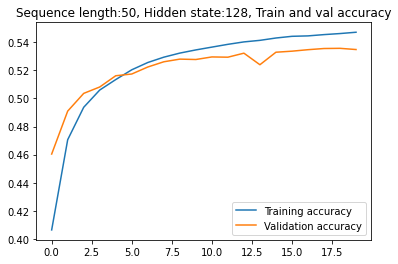

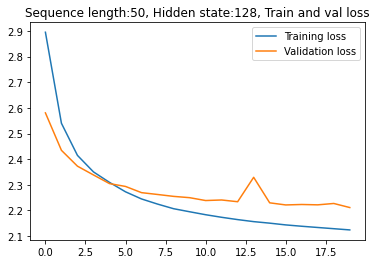

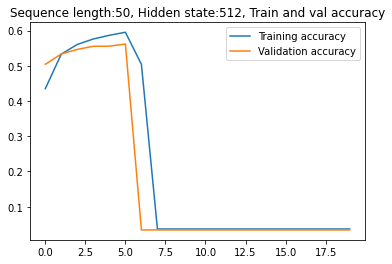

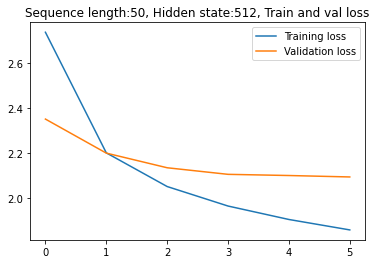

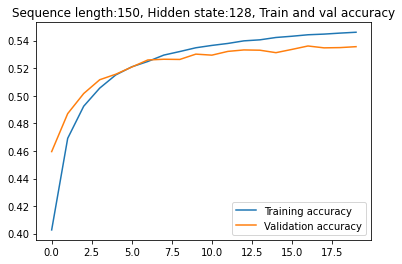

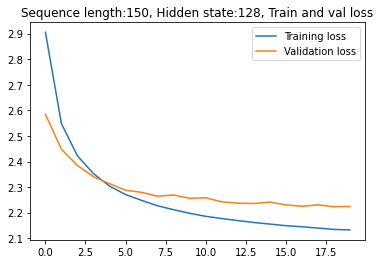

In [ ]:
sequence_lengths = [50, 150]
hidden_states = [128, 512]
for sequence_length in sequence_lengths:
    train_x, train_y = prepare_data(train_id, sequence_length, 5)
    val_x, val_y = prepare_data(val_id, sequence_length, 5)
    for hidden_state in hidden_states:
        model = build_model(sequence_length, hidden_state)
        history = model.fit(
          train_x, train_y,
          epochs = 20,
          batch_size = 64,
          validation_data=(val_x, val_y),
          verbose = 0
    )
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plot_training(acc,val_acc,'Sequence length:{}, Hidden state:{}, Train and val accuracy'.format(sequence_length, hidden_state), 'accuracy')
        plot_training(loss,val_loss,'Sequence length:{}, Hidden state:{}, Train and val loss'.format(sequence_length, hidden_state), 'loss')
              